In [18]:
# Initialisation of libraries/directories
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Img
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *

%matplotlib inline

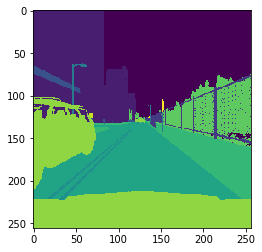

In [19]:
img=cv2.imread('/jet/prs/workspace/Data/Mask_data/MD/02_00_000.png') 
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)[:,:,2]
plt.imshow(img)

In [20]:
labels = list(np.unique(img))
labels

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]

In [21]:
import numpy as np
import cv2
import glob
import itertools
def generator(image_path, mask_path, batch_size, input_height, input_width, labels):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.png"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.png"  )
    segmentations.sort()
    
    #no of images in both folders is same
    assert len( images ) == len(segmentations)
    
    #Files are in correspondance
    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range( batch_size) :
            im , seg = next(zipped)
            
            img = cv2.imread(im)[:,:,::-1]
            img = img.astype(np.float32)
            img = img/255.0
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST )
            
            
            X.append(img)
            
            img1 = cv2.imread(seg)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)[:,:,2]
            
            seg_labels = np.zeros((  input_height , input_width  , len(labels)))
            
            
            
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
            #seg_labels = np.reshape(seg_labels, ( input_height*input_width , len(labels) ))
               
            Y.append(seg_labels)
            

        yield np.array(X) , np.array(Y)
    

In [25]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

In [46]:
# Data Augmentation
import numpy as np
import cv2
import glob
import itertools
def generator(image_path, mask_path, batch_size, input_height, input_width, labels):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.png"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.png"  )
    segmentations.sort()
    
    #no of images in both folders is same
    assert len( images ) == len(segmentations)
    
    #Files are in correspondance
    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range( batch_size) :
            im , seg = next(zipped)
            
            img = cv2.imread(im)[:,:,::-1]
            img = image_datagen.random_transform(img, seed=1)
            img = img.astype(np.float32)
            img = img/255.0
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            
            
            X.append(img)
            
            img1 = cv2.imread(seg)
            img1 = image_datagen.random_transform(img1, seed=1)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)[:,:,2]
#             img1 = image_datagen.random_transform(img1, seed=1)
            
            seg_labels = np.zeros((  input_height , input_width  , len(labels)))
            
            
            
            
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
#             seg_labels = np.reshape(seg_labels, ( input_height,input_width , len(labels) ))
               
            Y.append(seg_labels)
            

        yield np.array(X) , np.array(Y)
    

In [47]:
a = generator('/jet/prs/workspace/Data/Raw_Data/RD/' , '/jet/prs/workspace/Data/Mask_data/MD/', 5, 256,256,labels)

In [48]:
b,c =next(a)

In [49]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation
from scipy.io import loadmat

from keras.preprocessing.image import ImageDataGenerator, load_img

In [50]:
def Unet (nClasses , input_width , input_height ): 

    inputs = Input(( input_width, input_height,3))
    conv1 = Convolution2D(64, (3, 3), activation='relu',padding='same', kernel_initializer="he_normal", name='block1_conv1')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(64, (3, 3), activation='relu' ,padding='same',kernel_initializer="he_normal", name='block1_conv2')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Convolution2D(128, (3, 3), activation='relu',padding='same',kernel_initializer="he_normal", name='block2_conv1')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Convolution2D(128, (3, 3), activation='relu',padding='same', kernel_initializer="he_normal",name='block2_conv2')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Convolution2D(256, (3, 3), activation='relu',padding='same', kernel_initializer="he_normal",name='block3_conv1')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Convolution2D(256, (3, 3), activation='relu',padding='same', kernel_initializer="he_normal",name='block3_conv2')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    conv4 = Convolution2D(512, (3, 3), activation='relu',padding='same',kernel_initializer="he_normal", name='block4_conv1')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Convolution2D(512, (3, 3), activation='relu',padding='same', kernel_initializer="he_normal",name='block4_conv2')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    conv5 = Convolution2D(1024, (3, 3), activation='relu',padding='same',kernel_initializer="he_normal", name='block5_conv1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Convolution2D(1024, (3, 3), activation='relu',padding='same',kernel_initializer="he_normal", name='block5_conv2')(conv5)
    conv5 = BatchNormalization()(conv5)

    #up4 = Conv2DTranspose( 512 , kernel_size=(4,4) ,  strides=(2,2) , padding='same', use_bias=False, data_format='channels_last')(conv5)
    up1 = (UpSampling2D( (2,2)))(conv5)
    upconv1 = Convolution2D(512, (3, 3), padding='same', name='upblock1_conv1', data_format='channels_last')(up1)
    add1 = ( concatenate([ conv4 ,upconv1],axis=3 )  )
    add1 = Dropout(0.2)(add1)
    conv6 = Convolution2D(512, (3, 3), activation='relu', padding='same',kernel_initializer="he_normal", name='upblock1_conv2')(add1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Convolution2D(512, (3, 3), activation='relu', padding='same' ,kernel_initializer="he_normal",name='upblock1_conv3')(conv6)
    conv6 = BatchNormalization()(conv6)

    #up2 = Conv2DTranspose( 256 , kernel_size=(4,4) ,  strides=(2,2) , padding='same', use_bias=False, data_format='channels_last' )(conv6)
    up2 = (UpSampling2D( (2,2)))(conv6)
    upconv2 = Convolution2D(256, (3, 3), padding='same', name='upblock2_conv1')(up2)
    add2 = ( concatenate([ conv3 ,upconv2],axis=3 )  )
    add2 = Dropout(0.2)(add2)
    conv7 = Convolution2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal",name='upblock2_conv2')(add2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Convolution2D(256, (3, 3), activation='relu', padding='same' ,kernel_initializer="he_normal",name='upblock2_conv3')(conv7)
    conv7 = BatchNormalization()(conv7)

    up3 = (UpSampling2D( (2,2)))(conv7)
    upconv3 = Convolution2D(128, (3, 3), padding='same', name='upblock3_conv1')(up3)
    add3 = ( concatenate([ conv2 ,upconv3],axis=3 )  )
    add3 = Dropout(0.2)(add3)
    conv8 = Convolution2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal",name='upblock3_conv2')(add3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Convolution2D(128, (3, 3), activation='relu', padding='same' ,kernel_initializer="he_normal",name='upblock3_conv3')(conv8)
    conv8 = BatchNormalization()(conv8)

    up4 = (UpSampling2D( (2,2)))(conv8)
    upconv4 = Convolution2D(64, (3, 3), padding='same', name='upblock4_conv1')(up4)
    add4 = ( concatenate([ conv1 ,upconv4],axis=3 )  )
    add4 = Dropout(0.2)(add4)
    conv9 = Convolution2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal",name='upblock4_conv2')(add4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Convolution2D(64, (3, 3), activation='relu', padding='same' ,kernel_initializer="he_normal",name='upblock4_conv3')(conv9)
    conv9 = BatchNormalization()(conv9)

    o =  Convolution2D( nClasses , (3, 3) , padding='same')( conv9 )
#     o_shape = Model(inputs , o ).output_shape
#     outputHeight = o_shape[1]
#     outputWidth = o_shape[2]

#     o = (Reshape((   outputHeight*outputWidth, nClasses   )))(o)
    o = (Activation('softmax'))(o)
    model = Model( inputs , o )
    
    return model


In [51]:
from keras.optimizers import Adam, RMSprop 
from keras.metrics import categorical_crossentropy

model = Unet(12 ,256, 256 ) 

#model_dice = dice_loss(smooth=1e-5, thresh=0.5)

model.compile(loss='categorical_crossentropy', optimizer= Adam(lr=0.0001) , metrics=['accuracy'] )


In [60]:
b,c=next(a)

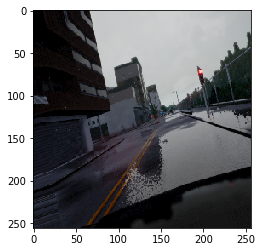

In [61]:
plt.imshow(b[0])

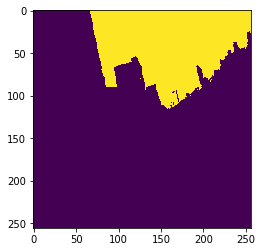

In [67]:
plt.imshow(c[0][:,:,0])

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [11]:
history = model.fit_generator( a , 1000  , epochs=10 )
model.save( "model_unet.h5")

Epoch 1/10
1000/1000 [==============================] - 266s 266ms/step - loss: 0.4714 - acc: 0.8619
Epoch 2/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.3370 - acc: 0.8977
Epoch 3/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.2976 - acc: 0.9092
Epoch 4/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.2629 - acc: 0.9202
Epoch 5/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.2398 - acc: 0.9267
Epoch 6/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.2221 - acc: 0.9317
Epoch 7/10
1000/1000 [==============================] - 256s 256ms/step - loss: 0.2102 - acc: 0.9348
Epoch 8/10
1000/1000 [==============================] - 256s 256ms/step - loss: 0.1948 - acc: 0.9394
Epoch 9/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.1814 - acc: 0.9436
Epoch 10/10
1000/1000 [==============================] - 257s 257ms/step - loss: 0.1677 - a

In [12]:
pr = model.predict(b)[0]

In [13]:
pr = pr.argmax( axis=2 )

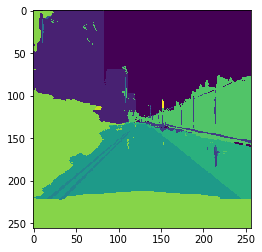

In [15]:
plt.imshow(pr)

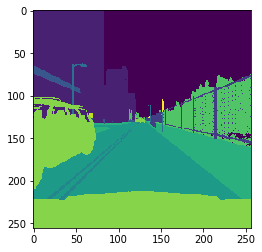

In [17]:
plt.imshow(c[0].argmax( axis=2 ))

def Unet (nClasses ,IMAGE_ORDERING , input_width , input_height ): 
    
    inputs = Input(( input_height, input_width,3))
    conv1 = Convolution2D(64, (3, 3), activation='relu',padding='same', name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    #conv1 = Dropout(0.2)(conv1)
    conv1 = Convolution2D(64, (3, 3), activation='relu' ,padding='same', name='block1_conv2', data_format=IMAGE_ORDERING)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(128, (3, 3), activation='relu',padding='same', name='block2_conv1', data_format=IMAGE_ORDERING)(pool1)
    #conv2 = Dropout(0.2)(conv2)
    conv2 = Convolution2D(128, (3, 3), activation='relu',padding='same', name='block2_conv2', data_format=IMAGE_ORDERING)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(256, (3, 3), activation='relu',padding='same', name='block3_conv1', data_format=IMAGE_ORDERING)(pool2)
    #conv3 = Dropout(0.2)(conv3)
    conv3 = Convolution2D(256, (3, 3), activation='relu',padding='same', name='block3_conv2', data_format=IMAGE_ORDERING)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
    conv6 = Convolution2D(512, (3, 3), activation='relu',padding='same', name='block6_conv1', data_format=IMAGE_ORDERING)(pool3)
    #conv6 = Dropout(0.2)(conv6)
    conv6 = Convolution2D(512, (3, 3), activation='relu',padding='same', name='block6_conv2', data_format=IMAGE_ORDERING)(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    conv8 = Convolution2D(1024, (3, 3), activation='relu',padding='same', name='block8_conv1', data_format=IMAGE_ORDERING)(pool6)
    #conv8 = Dropout(0.2)(conv8)
    conv8 = Convolution2D(1024, (3, 3), activation='relu',padding='same', name='block8_conv2', data_format=IMAGE_ORDERING)(conv8)


    up4 = Conv2DTranspose( 512 , kernel_size=(4,4) ,  strides=(2,2) , padding='same', use_bias=False, data_format=IMAGE_ORDERING )(conv8)
    Extra = int(((Model( inputs  , conv6).output_shape[1]) - (Model( inputs  , up4).output_shape[1]))/2)
    skip4 = Cropping2D(cropping = ((Extra,Extra),(Extra,Extra))  , data_format=IMAGE_ORDERING)(conv6)
    add4 = ( concatenate([ skip4 ,up4],axis=3 )  )
    conv9 = Convolution2D(512, (3, 3), activation='relu', padding='same', name='upblock4_conv1', data_format=IMAGE_ORDERING)(add4)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Convolution2D(512, (3, 3), activation='relu', padding='same' ,name='upblock4_conv2', data_format=IMAGE_ORDERING)(conv9)
    
    
    
    up3 = Conv2DTranspose( 256 , kernel_size=(4,4) ,  strides=(2,2) , padding='same', use_bias=False, data_format=IMAGE_ORDERING )(conv9)
    Extra = int(((Model( inputs  , conv3).output_shape[1]) - (Model( inputs  , up3).output_shape[1]))/2)
    skip3 = Cropping2D(cropping = ((Extra,Extra),(Extra,Extra))  , data_format=IMAGE_ORDERING)(conv3)
    add3 = ( concatenate([ skip3 ,up3],axis=3 )  )
    conv7 = Convolution2D(256, (3, 3), activation='relu', padding='same', name='upblock3_conv1', data_format=IMAGE_ORDERING)(add3)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Convolution2D(256, (3, 3), activation='relu', padding='same' ,name='upblock3_conv2', data_format=IMAGE_ORDERING)(conv7)
    
    

    up1 = Conv2DTranspose( 128 , kernel_size=(4,4) ,  strides=(2,2) , padding='same', use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    Extra = int(((Model( inputs  , conv2).output_shape[1]) - (Model( inputs  , up1).output_shape[1]))/2)
    skip1 = Cropping2D(cropping = ((Extra,Extra),(Extra,Extra))  , data_format=IMAGE_ORDERING)(conv2)
    add1 = ( concatenate([ skip1 ,up1],axis=3 )  )
    conv4 = Convolution2D(128, (3, 3), activation='relu', padding='same', name='upblock1_conv1', data_format=IMAGE_ORDERING)(add1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Convolution2D(128, (3, 3), activation='relu', padding='same' ,name='upblock1_conv2', data_format=IMAGE_ORDERING)(conv4)


    up2 = Conv2DTranspose( 64 , kernel_size=(4,4) ,  strides=(2,2) , padding='same', use_bias=False, data_format=IMAGE_ORDERING )(conv4)
    Extra = int(((Model( inputs  , conv1).output_shape[1]) - (Model( inputs  , up2).output_shape[1]))/2)
    skip2 = Cropping2D(cropping = ((Extra,Extra),(Extra,Extra))  , data_format=IMAGE_ORDERING)(conv1)
    add2 = ( concatenate([ skip2 ,up2],axis=3 )  )
    conv5 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='upblock2_conv1', data_format=IMAGE_ORDERING)(add2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Convolution2D(64, (3, 3), activation='relu', padding='same' ,name='upblock2_conv2', data_format=IMAGE_ORDERING)(conv5)


    o =  Conv2D( nClasses , (3, 3) , padding='same', data_format=IMAGE_ORDERING )( conv5 )
    o_shape = Model(inputs , o ).output_shape
    outputHeight = o_shape[1]
    outputWidth = o_shape[2]

    o = (Reshape((  nClasses , outputHeight*outputWidth   )))(o)
    o = (Permute((2, 1)))(o)
    o = (Activation('softmax'))(o)
    model = Model( inputs , o )
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight



    return model


import keras.backend as K
def dice_coef(y_true, y_pred, smooth, thresh):
#     print(y_pred)
#     print(y_pred.shape)
#     max_val=np.amax(y_pred, axis=2)
    
#     for i in range(max_val.shape[0]):
#         for j in range(max_val.shape[1]):
#             y_pred[i,j,:]=(y_pred[i,j,:]==max_val[i,j])*1
        
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(smooth, thresh):
    def dice(y_true, y_pred):
        a=0
        for i in range(5):
            a=a-dice_coef(y_true[i], y_pred[i], smooth, thresh)
        return 1+a/(5.)
    return dice



def dice_coef(y_true, y_pred, smooth=1):
    y_pred
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    print(y_true)
    print(y_pred)
#     return -dice_coef(y_true, y_pred)

In [175]:
pr = model.predict(b)[0]
pr = pr.reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 )

In [176]:
pr.shape

(256, 256)

In [88]:
pr.shape

(65536, 12)

In [93]:
max_val[0]

0.095921375

In [80]:
np.unique(pr)

array([ 0.,  1.], dtype=float32)

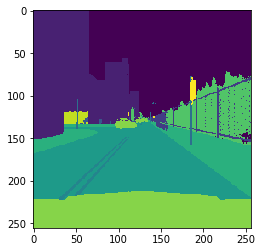

In [47]:
plt.imshow(c[4].reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 ))

In [51]:
c.shape

(5, 65536, 12)

In [49]:
pr.shape

(256, 256)

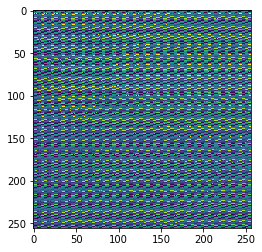

In [177]:
plt.imshow(pr)

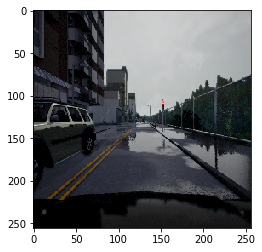

In [23]:
plt.imshow(b[4])

In [1]:
a = [1.1145 , 0.8796, 0.7686 , 0.7248 ,0.7041 ,  0.6917  , 0.6814 , 0.6740 , 0.6642 ,  0.6521  ]

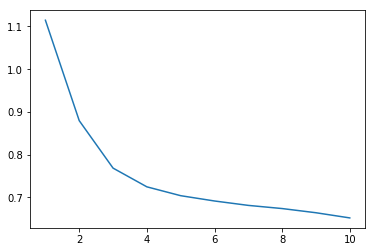

In [5]:
plt.plot([1,2,3,4,5,6,7,8,9,10], a)

In [59]:
1>2


False

In [108]:
a = np.arange(6)


In [109]:
b = np.reshape(a , (3, 2))

In [110]:
b

array([[0, 1],
       [2, 3],
       [4, 5]])

In [106]:
np.reshape(b, (1,6))

array([[0, 1, 2, 3, 4, 5]])

In [113]:
b[1,1]

3

In [112]:
b

array([[0, 1],
       [2, 3],
       [4, 5]])